In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt
import seaborn as sns
from datetime import date
import pandas as pd
import warnings
import scipy.stats as stats
warnings.simplefilter('ignore')
from sqlalchemy import cast, Date
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

The following is an analysis of weather data collected from various weather stations in Hawaii.  The data will be used to visualize the precipitation and temperature fluctuations throughout the year and a more focused look at what the weather is likely to be when I visit Hawaii later this year.  The date of my trip will be from 24 November to 30 November.

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save clases to variables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Inspect the data

In [7]:
inspector = inspect(engine)

In [8]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [10]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

First we will take a look at what the last years worth of data tells us about the percipitation in Hawaii.

In [12]:
# Find date to start query from
#pd.to_datetime used to convert last_date to a timestamp format, then pd.DateOffset used to subtract a year.  Documentation can be found at https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html, https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.tseries.offsets.DateOffset.html
year_ago = (pd.to_datetime(session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0])\
            - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
year_ago

'2016-08-23'

In [13]:
# Query precipitation for 12 month period
precp_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).order_by(Measurement.date).all()
precp_year[0]

('2016-08-23', 0.0)

In [14]:
# Convert to a dataFrame
precp_df = pd.DataFrame(precp_year, columns=['Date', 'Precipitation'])
precp_df = precp_df.dropna()
precp_df['Date'] = pd.to_datetime(precp_df['Date'])

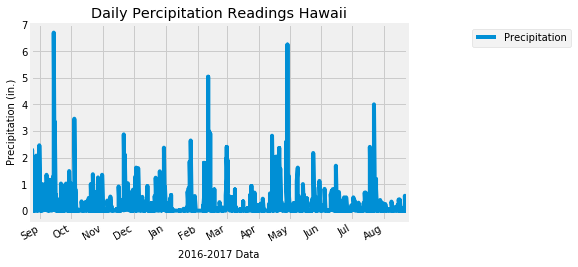

In [15]:
#Plot Percipitation data
months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%b')

fig, ax = plt.subplots()
ax.plot('Date', 'Precipitation', data=precp_df)
ax.legend(bbox_to_anchor=(1.45, 1.0))
ax.set_title('Daily Percipitation Readings Hawaii')
ax.set_ylabel('Precipitation (in.)', fontsize=10)
ax.text(0.5, -0.18, '2016-2017 Data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

# round to nearest years.
datemin = np.datetime64(precp_df['Date'][0], 'm') - np.timedelta64(1, 'm')
datemax = np.datetime64(precp_df['Date'].iloc[-1], 'm') + np.timedelta64(1, 'm')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
fig.autofmt_xdate()

plt.show()

Precipitation data statistics

In [16]:
precp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Dataset Facts

How man stations are in the Dataset?

In [17]:
# Design a query to show how many stations are available in this dataset?
station_count_s = session.query(Station.id).count()
print(f"There are {station_count_s} stations available in the Station dataset.")
station_count_m = session.query(distinct(Measurement.station)).count()
print(f"There are {station_count_m} stations available in the Measurement dataset.")

There are 9 stations available in the Station dataset.
There are 9 stations available in the Measurement dataset.


How many observations are recorded per weather station in the Dataset?

In [18]:
#Using a session query
station_freq = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_freq

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
#Using a dataframe which I think looks better
station_freq = session.query(Measurement.station).all()
station_freq_df = pd.DataFrame(station_freq, columns=['Station'])
station_freq_df = pd.value_counts(station_freq_df.Station).to_frame().reset_index()
station_freq_df.columns = ['Station ID', 'Observation Count']
station_freq_df

,Station ID,Observation Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


Find the most active weather station.

In [20]:
station_active = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]
station_active

'USC00519281'

What is the lowest temperature recorded at the most active weather station?

In [21]:
station_temp_lo = session.query(Measurement.station, Measurement.date, func.min(Measurement.tobs)).\
filter(Measurement.station == station_active).all()
print(f"The lowset temerature recoded in the dataset is {station_temp_lo[0][2]}\u00B0F recorded at station\
 {station_active} on {station_temp_lo[0][1]}.")

The lowset temerature recoded in the dataset is 54.0°F recorded at station USC00519281 on 2013-01-16.


What is the highest temperature recorded at the most active weather station?

In [22]:
station_temp_hi = session.query(Measurement.station, Measurement.date, func.max(Measurement.tobs)).\
filter(Measurement.station == station_active).all()
print(f"The highest temerature recoded in the dataset is {station_temp_hi[0][2]}\u00B0F recorded at station\
 {station_temp_hi[0][0]} on {station_temp_hi[0][1]}.")

The highest temerature recoded in the dataset is 85.0°F recorded at station USC00519281 on 2015-09-10.


What is the average temperature recorded at the most active weather station?

In [23]:
station_temp_avg = session.query(Measurement.station, Measurement.date, func.avg(Measurement.tobs)).\
filter(Measurement.station == station_active).all()
print(f"The average temerature recorded at station {station_temp_avg[0][0]} is {round(station_temp_avg[0][2], 1)}\u00B0F.")

The average temerature recorded at station USC00519281 is 71.7°F.


Which station was the most active station for temperature observations?

In [24]:
station_temp_active = session.query(Measurement.station, func.count(Measurement.tobs))\
    .group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
print(f"The most active station for temerapure observations is {station_temp_active[0]}\
with {station_temp_active[1]} temperature observations recorded.")

The most active station for temerapure observations is USC00519281with 2772 temperature observations recorded.


Create a list of temperature readings from the last year of data from the most active weather station.

In [25]:
year_ago_temp = (pd.to_datetime(session.query(func.max(Measurement.date)).filter(Measurement.station == station_temp_active.station).all()[0])\
            - pd.DateOffset(years=1)).strftime('%Y-%m-%d')[0]
year_ago_temp

'2016-08-18'

In [26]:
temp_year = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_ago_temp).\
    filter(Measurement.station == station_temp_active.station).order_by(Measurement.date).all()
temp_df = pd.DataFrame(temp_year, columns=['Temperature'])
temp_df.head(2)

,Temperature
0,80.0
1,79.0


<function matplotlib.pyplot.show(*args, **kw)>

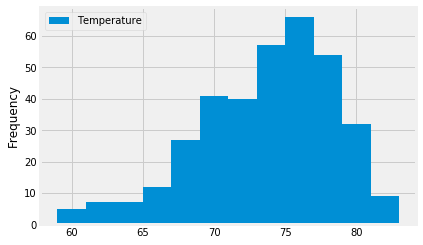

In [27]:
temp_df.plot.hist(bins=12)
plt.show

# Date range functions

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d

    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    print(start_date)
# function usage example
calc_temps('2012-02-28', '2012-03-05')

[(62.0, 69.57142857142857, 74.0)]

What is the minimum, average and maximum temperature for the date range of my vacation?

In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
results = calc_temps('2016-11-24', '2016-11-30')
print(f"The minimum temperature recorded {results[0][0]}\u00B0F \nThe average temperature of recoded values was {np.ravel(results[0][1])[0].astype(float).round(1)}\u00B0F\nThe maximum temperature recorded was {results[0][2]}\u00B0F")

The minimum temperature recorded 67.0°F 
The average temperature of recoded values was 74.1°F
The maximum temperature recorded was 78.0°F


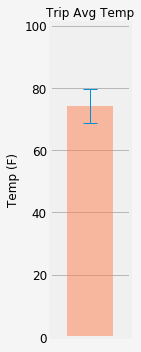

In [30]:
yerr = ((results[0][2] - results[0][0])/2)
fig = plt.figure(figsize=(2, 5))
fig.set_facecolor('whitesmoke')
ax = plt.axes()
plt.bar(0, results[0][1], color='coral', alpha = .5)
plt.errorbar(0, results[0][1], yerr=yerr, elinewidth=1, capsize=7)
ax.yaxis.grid(color='grey', linestyle='-', linewidth=.5)
ax.xaxis.grid()
plt.ylim(0, 101)
plt.xlim(-.7, .7)
plt.ylabel("Temp (F)", size=12)
plt.xticks([])
plt.yticks(size=12)
plt.title("Trip Avg Temp", size=12)
plt.tight_layout()
plt.show()

Calculate the total rainfall at each station for the date range of my trip.

In [31]:
def calc_prcp(start_date, end_date):
    sel = [Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
    station_rain = session.query(*sel).group_by(Measurement.station).filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).filter(Station.station == Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
    station_rain_df = pd.DataFrame(station_rain, columns=['Station Name', 'Latitude', 'Longitude', 'Elevation', 'Precipitation (in)'])
    station_rain_df = station_rain_df.dropna()
    return station_rain_df

calc_prcp('2016-11-24', '2016-11-30')

,Station Name,Latitude,Longitude,Elevation,Precipitation (in)
0,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.02
1,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.75
2,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.47
3,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.41
4,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.30
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.12


# Daily Normals

Use the function daily_normals(start_date, end_date) to create a dataFrame of the min, avg, and max temeratures for the time period of the trip.  These values are derived from historical data within the dataset.  The dates mus be entered in Y-M-D format.

In [32]:
def daily_normals(start_date, end_date):
    daily_norm = []  
    while pd.to_datetime(start_date) < pd.to_datetime(end_date):
        filter_date = pd.to_datetime(start_date).strftime("%m-%d")
        sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
        daily_norm_new = session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == filter_date).all()
        
        for min, avg, max in daily_norm_new:
                daily_dict = {}
                daily_dict["Date"] = pd.to_datetime(start_date).strftime("%m-%d")
                daily_dict["Min Temp (F)"] = min
                daily_dict["Avg Temp (F)"] = round(avg,1)
                daily_dict["Max Temp (F)"] = max
                daily_norm.append(daily_dict)
        
        start_date = pd.to_datetime(start_date) + dt.timedelta(days=1)
    daily_norm_df = pd.DataFrame(daily_norm, columns = ['Date', 'Min Temp (F)', 'Avg Temp (F)', 'Max Temp (F)'])
    daily_norm_df = daily_norm_df.set_index('Date')
    return daily_norm_df

In [33]:
# For my trip
trip_normals = daily_normals("2016-11-24", "2016-11-30")
trip_normals

,Min Temp (F),Avg Temp (F),Max Temp (F)
Date,,,
11-24,66.0,72.6,77.0
11-25,63.0,72.4,78.0
11-26,67.0,73.5,78.0
11-27,63.0,73.0,78.0
11-28,62.0,72.8,80.0
11-29,62.0,71.0,79.0


(array([0., 1., 2., 3., 4., 5.]), <a list of 6 Text xticklabel objects>)

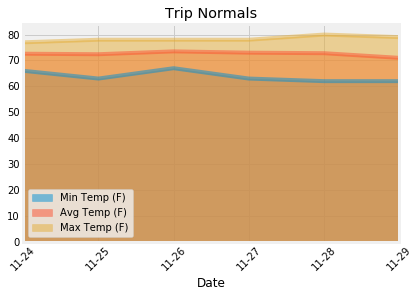

In [34]:
trip_normals.plot(kind='area', stacked=False, alpha=0.5,
        title='Trip Normals')
plt.xticks(rotation=45)

In [35]:
def daily_normals_all(month):
    start_date = '2000-01-01'
    end_date = '2019-01-01'
    daily_norm = []  
    while pd.to_datetime(start_date) < pd.to_datetime(end_date):
        filter_date = pd.to_datetime(start_date).strftime("%m-%d")
        sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
        daily_norm_new = session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == filter_date).all()
        
        for min, avg, max in daily_norm_new:
                daily_dict = {}
                daily_dict["Date"] = pd.to_datetime(start_date).strftime("%m")
                daily_dict["Min Temp (F)"] = min
                daily_dict["Avg Temp (F)"] = round(avg,1)
                daily_dict["Max Temp (F)"] = max
                daily_norm.append(daily_dict)
        
        start_date = pd.to_datetime(start_date) + dt.timedelta(days=1)
    daily_norm_df = pd.DataFrame(daily_norm, columns = ['Date', 'Min Temp (F)', 'Avg Temp (F)', 'Max Temp (F)'])
    #daily_norm_df = daily_norm_df.set_index('Date')
    return daily_norm_df

In [36]:
dataFrame = daily_normals_all("6")

In [37]:
dataFrame.head()

,Date,Min Temp (F),Avg Temp (F),Max Temp (F)
0,01,62.0,69.2,77.0
1,01,60.0,69.4,77.0
2,01,62.0,68.9,77.0
3,01,58.0,70.0,76.0
4,01,56.0,68.0,76.0


In [38]:
june = dataFrame.loc[dataFrame['Date'] == '06']
december = dataFrame.loc[dataFrame['Date'] == '12']

In [39]:
december.describe()

,Min Temp (F),Avg Temp (F),Max Temp (F)
count,589.000000,589.000000,589.000000
mean,62.774194,71.032258,78.516129
std,2.816064,1.069035,1.564431
min,56.000000,68.300000,76.000000
25%,61.000000,70.300000,77.000000
50%,63.000000,71.200000,78.000000
75%,65.000000,71.900000,79.000000
max,67.000000,72.900000,83.000000


In [40]:
june.describe()

,Min Temp (F),Avg Temp (F),Max Temp (F)
count,570.000000,570.000000,570.000000
mean,67.733333,74.950000,81.266667
std,1.549118,0.567802,1.237569
min,64.000000,73.800000,80.000000
25%,67.000000,74.600000,81.000000
50%,68.000000,75.000000,81.000000
75%,69.000000,75.400000,81.000000
max,70.000000,76.000000,85.000000


Using the Unpaired Student T Test to determine if the temperature year round are similar in Hawaii.

In [41]:
stats.ttest_ind(june['Avg Temp (F)'], december['Avg Temp (F)'], equal_var=False)

Ttest_indResult(statistic=78.26239285798216, pvalue=0.0)

With the resulting pvalue of 0, it can be determined that there is no significant difference between the temperatures in June and December, therfore proving that Hawaii does in fact enjoy mild temperatures all year.